# Sales of Alcohol Prediction using LSTM

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. ETL

In [2]:
df = pd.read_csv('../data/Alcohol_Sales.csv')
df.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [3]:
len(df)

325

In [5]:
df = df.rename(columns = {'S4248SM144NCEN': 'Sales'})
df.columns

Index(['DATE', 'Sales'], dtype='object')

## 2. EDA

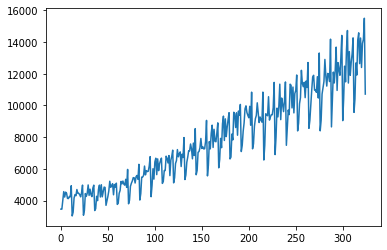

In [6]:
plt.plot(df['Sales'])